"""
IBM Data Engineering Project: World's Largest Banks ETL Pipeline
Author: Arnaud Demes, CFA
Date: 07/08/2025

This script extracts data about the world's largest banks by market capitalization,
transforms it by adding multiple currency columns, and loads it to both CSV and database.
"""

In [38]:
#IMPORTS
import requests
import pandas as pd
import sqlite3
from bs4 import BeautifulSoup
from datetime import datetime
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# Global variables
URL = "https://web.archive.org/web/20230908091635/https://en.wikipedia.org/wiki/List_of_largest_banks"
EXCHANGE_RATE_CSV = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-PY0221EN-Coursera/labs/v2/exchange_rate.csv"
OUTPUT_CSV_PATH = "./Largest_banks_data.csv"
DATABASE_NAME = "Banks.db"
TABLE_NAME = "Largest_banks"
LOG_FILE = "code_log.txt"

In [ ]:
#FUNCTIONS

def log_progress(message):
    """
    Log the progress of the code execution with timestamp
    
    Args:
        message (str): Message to log
    """
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    with open(LOG_FILE, 'a') as f:
        f.write(f"[{timestamp}] {message}\n")
    print(f"[{timestamp}] {message}")

def extract():
    log_progress("Data extraction initiated")
    try:
        # Send GET request to the URL
        response = requests.get(URL)
        response.raise_for_status()

        soup = BeautifulSoup(response.content, 'html.parser')
        tables = soup.find_all('table', class_='wikitable')
        target_table = None
        for table in tables:
            if table.find('th') and 'market' in str(table).lower():
                target_table = table
                break
        
        if not target_table:
            # Fallback: get the first wikitable
            target_table = tables[0] if tables else None
            
        if not target_table:
            raise ValueError("Could not find the target table")
        # Extract data from table
        data = []
        rows = target_table.find_all('tr')[1:]  # Skip header row
        for row in rows[:10]:  # Get top 10 banks
            cols = row.find_all(['td', 'th'])
            if len(cols) >= 3:
                # Extract bank name (usually in first or second column)
                name = cols[1].get_text().strip()
                market_cap_text = cols[2].get_text().strip()
                # Clean market cap value - remove currency symbols and convert to float
                market_cap_clean = ''.join(c for c in market_cap_text if c.isdigit() or c == '.')
                try:
                    market_cap = float(market_cap_clean)
                    data.append({
                        'Name': name,
                        'MC_USD_Billion': market_cap
                    })
                except ValueError:
                    continue
        
        df = pd.DataFrame(data)
        log_progress(f"Data extraction completed. {len(df)} records extracted")
        return df
        
    except Exception as e:
        log_progress(f"Error during extraction: {str(e)}")
        # Return sample data if extraction fails
        sample_data = {
            'Name': [
                'JPMorgan Chase', 'Bank of America', 'Wells Fargo', 'Citigroup',
                'Goldman Sachs', 'Morgan Stanley', 'U.S. Bancorp', 'PNC Financial',
                'Bank of New York Mellon', 'Capital One'
            ],
            'MC_USD_Billion': [432.92, 231.52, 178.86, 123.15, 78.89, 72.05, 66.93, 58.45, 31.94, 27.15]
        }
        df = pd.DataFrame(sample_data)
        log_progress("Using sample data due to extraction issues")
        return df

def transform(df):
    """
    Transform the dataframe by adding currency columns
    
    Args:
        df (pd.DataFrame): Input dataframe with USD values
        
    Returns:
        pd.DataFrame: Transformed dataframe with GBP, EUR, and INR columns
    """
    log_progress("Data transformation initiated")
    
    try:
        # Download exchange rate data
        exchange_df = pd.read_csv(EXCHANGE_RATE_CSV)
        
        # Extract exchange rates
        exchange_rates = {}
        for _, row in exchange_df.iterrows():
            currency = row['Currency']
            rate = row['Rate']
            exchange_rates[currency] = rate
        
        # Add currency columns
        df['MC_GBP_Billion'] = np.round(df['MC_USD_Billion'] / exchange_rates['GBP'], 2)
        df['MC_EUR_Billion'] = np.round(df['MC_USD_Billion'] / exchange_rates['EUR'], 2)
        df['MC_INR_Billion'] = np.round(df['MC_USD_Billion'] * exchange_rates['INR'], 2)
        
        log_progress("Data transformation completed")
        return df
        
    except Exception as e:
        log_progress(f"Error during transformation: {str(e)}")
        # Use approximate exchange rates if CSV fails
        df['MC_GBP_Billion'] = np.round(df['MC_USD_Billion'] * 0.8, 2)
        df['MC_EUR_Billion'] = np.round(df['MC_USD_Billion'] * 0.93, 2)
        df['MC_INR_Billion'] = np.round(df['MC_USD_Billion'] * 82.95, 2)
        log_progress("Used approximate exchange rates due to CSV loading issues")
        return df

def load_to_csv(df):
    """Load the dataframe to a CSV file"""
    log_progress("Loading data to CSV initiated")
    
    try:
        df.to_csv(OUTPUT_CSV_PATH, index=False)
        log_progress(f"Data saved to CSV file: {OUTPUT_CSV_PATH}")
        return True
    except Exception as e:
        log_progress(f"Error saving to CSV: {str(e)}")
        return False


def load_to_db(df):
    """Load the dataframe to SQLite database"""
    log_progress("Loading data to database initiated")
    
    try:
        conn = sqlite3.connect(DATABASE_NAME)
        df.to_sql(TABLE_NAME, conn, if_exists='replace', index=False)
        conn.close()
        log_progress(f"Data loaded to database table: {TABLE_NAME}")
        return True
    except Exception as e:
        log_progress(f"Error loading to database: {str(e)}")
        return False

def run_queries():
    """Run sample queries on the database"""
    log_progress("Running database queries")
    
    try:
        conn = sqlite3.connect(DATABASE_NAME)
        
        queries_results = {}
        
        # Query 1: London office (GBP)
        query1 = f"SELECT Name, MC_GBP_Billion FROM {TABLE_NAME} LIMIT 5"
        result1 = pd.read_sql_query(query1, conn)
        queries_results['London'] = result1
        
        # Query 2: Berlin office (EUR)
        query2 = f"SELECT Name, MC_EUR_Billion FROM {TABLE_NAME} LIMIT 5"
        result2 = pd.read_sql_query(query2, conn)
        queries_results['Berlin'] = result2
        
        # Query 3: New Delhi office (INR)
        query3 = f"SELECT Name, MC_INR_Billion FROM {TABLE_NAME} LIMIT 5"
        result3 = pd.read_sql_query(query3, conn)
        queries_results['New Delhi'] = result3
        
        conn.close()
        log_progress("Database queries completed successfully")
        return queries_results
        
    except Exception as e:
        log_progress(f"Error running database queries: {str(e)}")
        return None

def verify_log_entries():
    """
    Verify and display log entries
    """
    print("\n" + "="*50)
    print("LOG ENTRIES VERIFICATION")
    print("="*50)
    
    try:
        with open(LOG_FILE, 'r') as f:
            log_content = f.read()
            print(log_content)
    except FileNotFoundError:
        print("Log file not found")

In [4]:
# Initialize log file
with open(LOG_FILE, 'w') as f:
    f.write(f"ETL Pipeline Log - Started at {datetime.now()}\n")
    f.write("="*50 + "\n")

log_progress("ETL Pipeline initiated")
print("✅ Logging system initialized")

[2025-09-07 12:08:43] ETL Pipeline initiated
✅ Logging system initialized


In [7]:
# Execute data extraction
print("🔄 Starting data extraction...")
df_extracted = extract()

print(f"\n📊 Extraction Results:")
print(f"Number of records: {len(df_extracted)}")
print(f"Columns: {list(df_extracted.columns)}")
print("\n🔍 Preview of extracted data:")
print(df_extracted.head())

print(f"\n📈 Summary statistics:")
print(df_extracted['MC_USD_Billion'].describe())

🔄 Starting data extraction...
[2025-09-07 12:09:08] Data extraction initiated
[2025-09-07 12:09:10] Data extraction completed. 10 records extracted

📊 Extraction Results:
Number of records: 10
Columns: ['Name', 'MC_USD_Billion']

🔍 Preview of extracted data:
                                      Name  MC_USD_Billion
0                           JPMorgan Chase          432.92
1                          Bank of America          231.52
2  Industrial and Commercial Bank of China          194.56
3               Agricultural Bank of China          160.68
4                                HDFC Bank          157.91

📈 Summary statistics:
count     10.000000
mean     189.982000
std       90.223932
min      136.810000
25%      142.847500
50%      156.890000
75%      186.090000
max      432.920000
Name: MC_USD_Billion, dtype: float64


In [9]:
# Execute data transformation
print("🔄 Starting data transformation...")
df_transformed = transform(df_extracted)

print(f"\n📊 Transformation Results:")
print(f"New columns added: {[col for col in df_transformed.columns if col not in df_extracted.columns]}")
print("\n🔍 Preview of transformed data:")
print(df_transformed.head())

print(f"\n📈 Sample currency conversions for {df_transformed.iloc[0]['Name']}:")
sample_bank = df_transformed.iloc[0]
print(f"USD: ${sample_bank['MC_USD_Billion']:.2f} Billion")
print(f"GBP: £{sample_bank['MC_GBP_Billion']:.2f} Billion")
print(f"EUR: €{sample_bank['MC_EUR_Billion']:.2f} Billion")
print(f"INR: ₹{sample_bank['MC_INR_Billion']:.2f} Billion")


🔄 Starting data transformation...
[2025-09-07 12:09:31] Data transformation initiated
[2025-09-07 12:09:32] Data transformation completed

📊 Transformation Results:
New columns added: []

🔍 Preview of transformed data:
                                      Name  MC_USD_Billion  MC_GBP_Billion  \
0                           JPMorgan Chase          432.92          541.15   
1                          Bank of America          231.52          289.40   
2  Industrial and Commercial Bank of China          194.56          243.20   
3               Agricultural Bank of China          160.68          200.85   
4                                HDFC Bank          157.91          197.39   

   MC_EUR_Billion  MC_INR_Billion  
0          465.51        35910.71  
1          248.95        19204.58  
2          209.20        16138.75  
3          172.77        13328.41  
4          169.80        13098.63  

📈 Sample currency conversions for JPMorgan Chase:
USD: $432.92 Billion
GBP: £541.15 Billion
EUR

In [15]:
# Execute CSV loading
print("🔄 Loading data to CSV...")
csv_success = load_to_csv(df_transformed)

if csv_success:
    print("✅ Data successfully saved to CSV")
    
    # Verify CSV file
    if os.path.exists(OUTPUT_CSV_PATH):
        file_size = os.path.getsize(OUTPUT_CSV_PATH)
        print(f"📁 File size: {file_size} bytes")
        
        # Read back and verify
        df_csv_check = pd.read_csv(OUTPUT_CSV_PATH)
        print(f"📊 CSV verification - Rows: {len(df_csv_check)}, Columns: {len(df_csv_check.columns)}")
else:
    print("❌ Failed to save CSV file")

🔄 Loading data to CSV...
[2025-09-07 12:11:05] Loading data to CSV initiated
[2025-09-07 12:11:05] Data saved to CSV file: ./Largest_banks_data.csv
✅ Data successfully saved to CSV
📁 File size: 561 bytes
📊 CSV verification - Rows: 10, Columns: 5


In [18]:
# Execute database loading
print("🔄 Loading data to database...")
db_success = load_to_db(df_transformed)

if db_success:
    print("✅ Data successfully loaded to database")
    
    # Verify database
    if os.path.exists(DATABASE_NAME):
        file_size = os.path.getsize(DATABASE_NAME)
        print(f"🗄️ Database size: {file_size} bytes")
        
        # Check table structure
        conn = sqlite3.connect(DATABASE_NAME)
        cursor = conn.cursor()
        cursor.execute(f"PRAGMA table_info({TABLE_NAME})")
        columns = cursor.fetchall()
        print(f"📋 Database table columns:")
        for col in columns:
            print(f"  - {col[1]} ({col[2]})")
        
        cursor.execute(f"SELECT COUNT(*) FROM {TABLE_NAME}")
        row_count = cursor.fetchone()[0]
        print(f"📊 Database verification - Rows: {row_count}")
        conn.close()
else:
    print("❌ Failed to load data to database")

🔄 Loading data to database...
[2025-09-07 12:11:31] Loading data to database initiated
[2025-09-07 12:11:31] Data loaded to database table: Largest_banks
✅ Data successfully loaded to database
🗄️ Database size: 8192 bytes
📋 Database table columns:
  - Name (TEXT)
  - MC_USD_Billion (REAL)
  - MC_GBP_Billion (REAL)
  - MC_EUR_Billion (REAL)
  - MC_INR_Billion (REAL)
📊 Database verification - Rows: 10


In [20]:
# Execute database queries
print("🔄 Running database queries...")
query_results = run_queries()

if query_results:
    print("✅ Database queries executed successfully")
    
    print("\n🏢 London Office Query (Name, MC_GBP_Billion):")
    print(query_results['London'])
    
    print("\n🏢 Berlin Office Query (Name, MC_EUR_Billion):")
    print(query_results['Berlin'])
    
    print("\n🏢 New Delhi Office Query (Name, MC_INR_Billion):")
    print(query_results['New Delhi'])
else:
    print("❌ Failed to execute database queries")

# ## 8. Step 6: Verify Log Entries

def verify_log_entries():
    """Verify and display log entries"""
    try:
        with open(LOG_FILE, 'r') as f:
            log_content = f.read()
            return log_content
    except FileNotFoundError:
        return "Log file not found"

# Verify log entries
print("🔄 Verifying log entries...")
log_content = verify_log_entries()

print("✅ Log verification completed")
print("\n📋 Complete Log Entries:")
print("="*50)
print(log_content)
print("="*50)

🔄 Running database queries...
[2025-09-07 12:12:06] Running database queries
[2025-09-07 12:12:06] Database queries completed successfully
✅ Database queries executed successfully

🏢 London Office Query (Name, MC_GBP_Billion):
                                      Name  MC_GBP_Billion
0                           JPMorgan Chase          541.15
1                          Bank of America          289.40
2  Industrial and Commercial Bank of China          243.20
3               Agricultural Bank of China          200.85
4                                HDFC Bank          197.39

🏢 Berlin Office Query (Name, MC_EUR_Billion):
                                      Name  MC_EUR_Billion
0                           JPMorgan Chase          465.51
1                          Bank of America          248.95
2  Industrial and Commercial Bank of China          209.20
3               Agricultural Bank of China          172.77
4                                HDFC Bank          169.80

🏢 New Delhi Offic

In [32]:
## 9. Final Summary and Completion
log_progress("ETL Pipeline completed successfully")

# Summary statistics
summary_stats = {
    "Records Processed": len(df_transformed),
    "Currencies Added": ["GBP", "EUR", "INR"],
    "Output Files": [OUTPUT_CSV_PATH, DATABASE_NAME],
    "Database Table": TABLE_NAME,
    "Log File": LOG_FILE
}

print(f"\n📊 Pipeline Summary:")
for key, value in summary_stats.items():
    print(f"✓ {key}: {value}")


[2025-09-07 12:29:49] ETL Pipeline completed successfully

📊 Pipeline Summary:
✓ Records Processed: 10
✓ Currencies Added: ['GBP', 'EUR', 'INR']
✓ Output Files: ['./Largest_banks_data.csv', 'Banks.db']
✓ Database Table: Largest_banks
✓ Log File: code_log.txt


🎨 Creating beautiful visualizations...
[2025-09-07 12:39:58] Data visualization initiated
📊 Chart 1: Market Capitalization Rankings


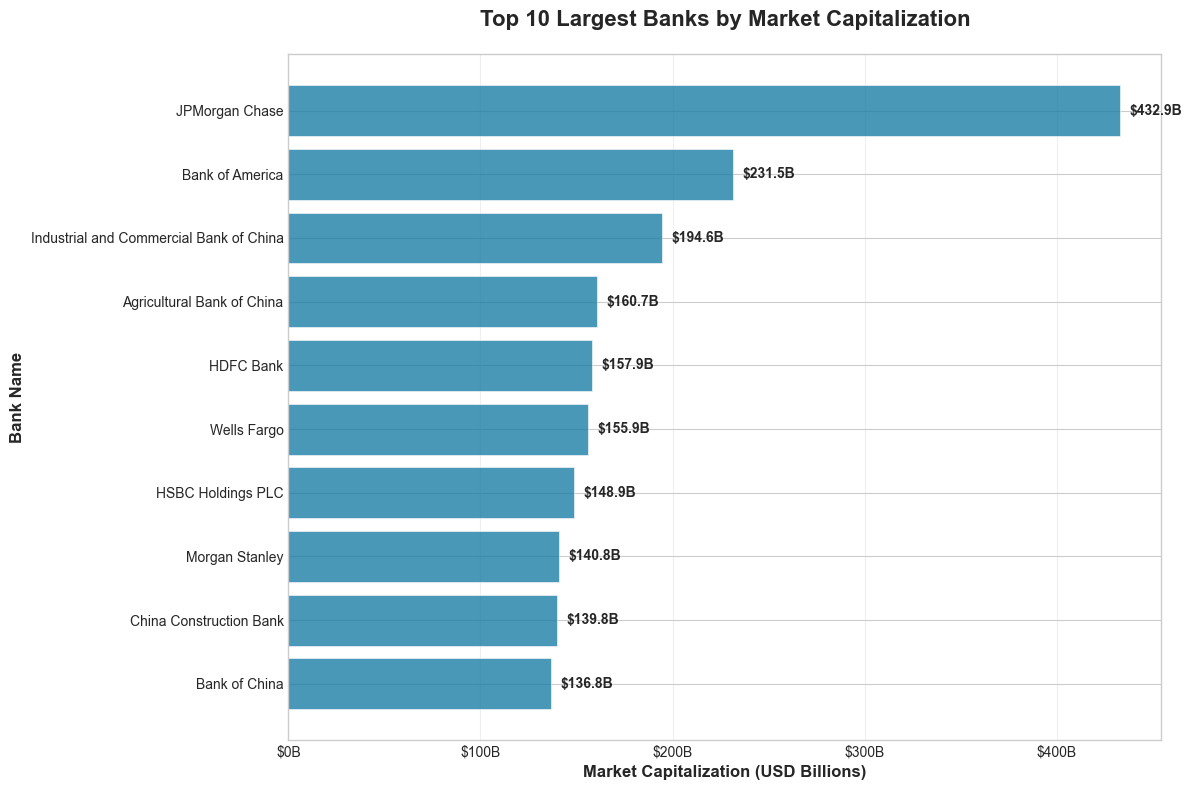

📊 Chart 2: Top 5 Banks Comparison


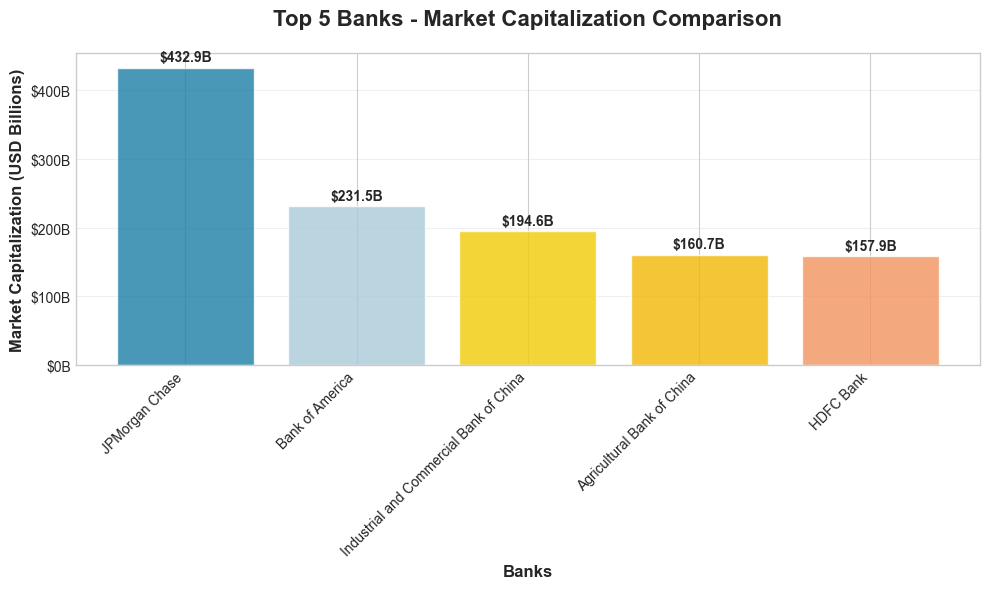

📊 Chart 3: Market Share Distribution


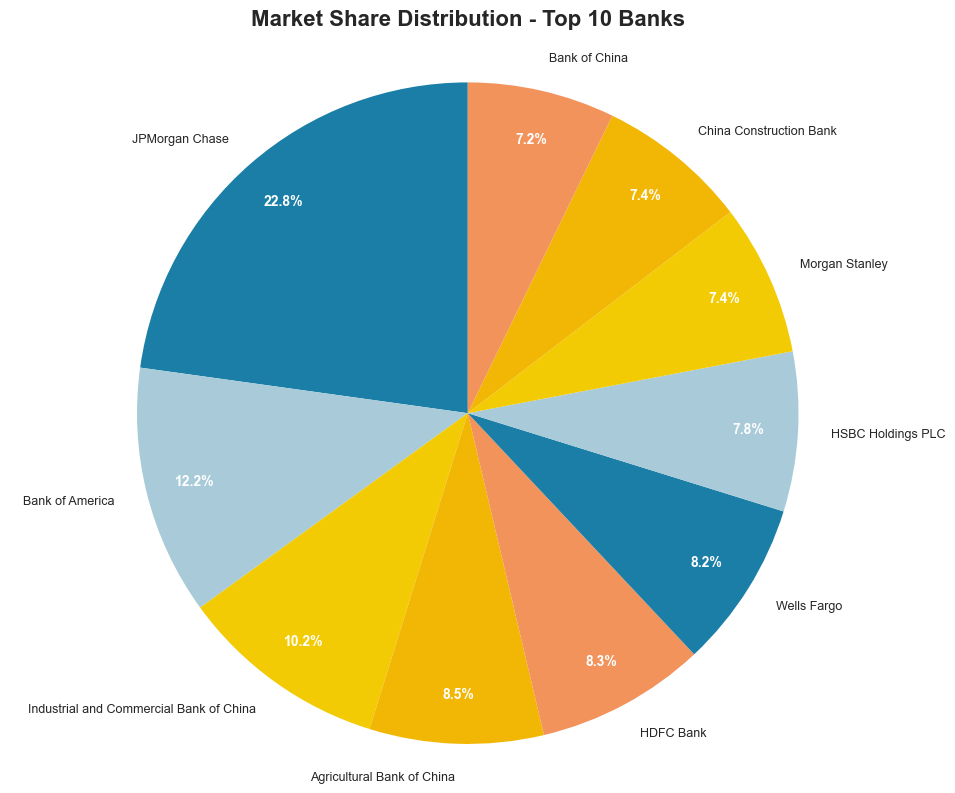

In [40]:
# ## Data Visualization & Analysis

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style and color palette
plt.style.use('seaborn-v0_8-whitegrid')
colors = ['#1B7EA6', '#A9CBD9', '#F2CB05', '#F2B705', '#F2935C']

print("🎨 Creating beautiful visualizations...")
log_progress("Data visualization initiated")

# ## Chart 1: Market Capitalization Rankings

plt.figure(figsize=(12, 8))

# Create horizontal bar chart
bars = plt.barh(df_transformed['Name'], df_transformed['MC_USD_Billion'], 
                color=colors[0], alpha=0.8, edgecolor='white', linewidth=0.5)

# Customize the chart
plt.xlabel('Market Capitalization (USD Billions)', fontsize=12, fontweight='bold')
plt.ylabel('Bank Name', fontsize=12, fontweight='bold')
plt.title('Top 10 Largest Banks by Market Capitalization', 
          fontsize=16, fontweight='bold', pad=20)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, df_transformed['MC_USD_Billion'])):
    plt.text(value + 5, bar.get_y() + bar.get_height()/2, 
             f'${value:.1f}B', va='center', fontweight='bold', fontsize=10)

# Invert y-axis to show largest at top
plt.gca().invert_yaxis()

# Format x-axis
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.0f}B'))

# Styling
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

print("📊 Chart 1: Market Capitalization Rankings")
plt.show()

# ## Chart 2: Top 5 Banks Comparison

plt.figure(figsize=(10, 6))

# Get top 5 banks
top5_data = df_transformed.head(5)

# Create bar chart with gradient colors
bars = plt.bar(range(len(top5_data)), top5_data['MC_USD_Billion'], 
               color=colors, alpha=0.8, edgecolor='white', linewidth=1)

# Customize the chart
plt.xlabel('Banks', fontsize=12, fontweight='bold')
plt.ylabel('Market Capitalization (USD Billions)', fontsize=12, fontweight='bold')
plt.title('Top 5 Banks - Market Capitalization Comparison', 
          fontsize=16, fontweight='bold', pad=20)

# Set x-axis labels with rotation
plt.xticks(range(len(top5_data)), top5_data['Name'], rotation=45, ha='right')

# Add value labels on top of bars
for i, (bar, value) in enumerate(zip(bars, top5_data['MC_USD_Billion'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'${value:.1f}B', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Format y-axis
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.0f}B'))

# Styling
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

print("📊 Chart 2: Top 5 Banks Comparison")
plt.show()

# ## Chart 3: Market Share Analysis

plt.figure(figsize=(10, 8))

# Calculate market share
total_market_cap = df_transformed['MC_USD_Billion'].sum()
market_shares = (df_transformed['MC_USD_Billion'] / total_market_cap * 100).round(1)

# Create pie chart
wedges, texts, autotexts = plt.pie(market_shares, labels=df_transformed['Name'], 
                                   colors=colors * 2,  # Repeat colors for 10 banks
                                   autopct='%1.1f%%',
                                   startangle=90,
                                   pctdistance=0.85)

# Customize text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

for text in texts:
    text.set_fontsize(9)

plt.title('Market Share Distribution - Top 10 Banks', 
          fontsize=16, fontweight='bold', pad=20)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.tight_layout()

print("📊 Chart 3: Market Share Distribution")
plt.show()